# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp312-cp312-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [smdebug]m3/4 [smdebug]]


In [2]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

In [5]:
import os

# Check if the dataset directory already exists
if not os.path.exists('dogImages'):
    print("Downloading dataset...")
    !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
    print("Unzipping dataset...")
    !unzip -q dogImages.zip  # -q for quiet mode
    print("Dataset ready!")
else:
    print("Dataset already exists, skipping download.")

Dataset already exists, skipping download.


In [6]:
# Set up the S3 bucket and prefix
bucket = sagemaker.Session().default_bucket()
prefix = 'dogImages'

In [7]:
# Upload the data to S3
s3_train_path = f's3://{bucket}/{prefix}/train'
s3_valid_path = f's3://{bucket}/{prefix}/valid'
s3_test_path = f's3://{bucket}/{prefix}/test'

# Upload the different datasets to S3
!aws s3 cp dogImages/train $s3_train_path --recursive
!aws s3 cp dogImages/valid $s3_valid_path --recursive
!aws s3 cp dogImages/test $s3_test_path --recursive

# Print the S3 paths for reference
print(f"Training data uploaded to: {s3_train_path}")
print(f"Validation data uploaded to: {s3_valid_path}")
print(f"Test data uploaded to: {s3_test_path}")

upload: dogImages/train/001.Affenpinscher/Affenpinscher_00004.jpg to s3://sagemaker-us-east-1-137068255283/dogImages/train/001.Affenpinscher/Affenpinscher_00004.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00002.jpg to s3://sagemaker-us-east-1-137068255283/dogImages/train/001.Affenpinscher/Affenpinscher_00002.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00006.jpg to s3://sagemaker-us-east-1-137068255283/dogImages/train/001.Affenpinscher/Affenpinscher_00006.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg to s3://sagemaker-us-east-1-137068255283/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00005.jpg to s3://sagemaker-us-east-1-137068255283/dogImages/train/001.Affenpinscher/Affenpinscher_00005.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00012.jpg to s3://sagemaker-us-east-1-137068255283/dogImages/train/001.Affenpinscher/Affenpinscher_00012.jpg
upload: do

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch-dog-hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py3',
    hyperparameters={
        'batch_size': 64,           # Make sure this is an integer
        'learning_rate': 0.01
    }
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)


In [10]:

# Train the model
estimator.fit({
    "training": s3_train_path,
    "validation": s3_valid_path,
    "testing": s3_test_path
})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-dog-hpo-2025-06-16-12-14-27-613


2025-06-16 12:14:28 Starting - Starting the training job...
2025-06-16 12:14:52 Starting - Preparing the instances for training...
2025-06-16 12:15:12 Downloading - Downloading input data......
2025-06-16 12:16:26 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-06-16 12:16:36,909 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-06-16 12:16:36,912 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2025-06-16 12:16:36,924 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-06-16 12:16:36,926 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-06-16 12:16:37,111 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2025-06-16 12:16:37,111 sagemaker-contai

In [12]:
# TODO: Get the best estimators and the best HPs

best_hyperparams = estimator.hyperparameters()#Get the hyperparameters of the best trained model
print(f"Hyperparameters used: {best_hyperparams}")

# best_estimator.hyperparameters()

Hyperparameters used: {'batch_size': '64', 'learning_rate': '0.01', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-137068255283/pytorch-dog-hpo-2025-06-16-12-14-27-613/source/sourcedir.tar.gz"', 'sagemaker_program': '"hpo.py"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-dog-hpo-2025-06-16-12-14-27-613"', 'sagemaker_region': '"us-east-1"'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [13]:
# Model Profiling and Debugging - Fixed for current SageMaker SDK
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, rule_configs, CollectionConfig, DebuggerHookConfig
from sagemaker.debugger import ProfilerRule, ProfilerConfig, FrameworkProfile
import boto3

# Set up session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

print("Setting up profiler and debugger configurations...")

# Define profiler rules (using safe approach)
available_profiler_rules = []

# List of profiler rules to try
profiler_rule_names = [
    'ProfilerReport',
    'CPUBottleneck', 
    'GPUMemoryIncrease',
    'IOBottleneck',
    'LoadBalancing',
    'LowGPUUtilization',
    'OverallSystemUsage',
    'MaxInitializationTime',
    'StepOutlier',
    'BatchSize',
]

# Dynamically add only available rules
for rule_name in profiler_rule_names:
    try:
        if hasattr(rule_configs, rule_name):
            rule_func = getattr(rule_configs, rule_name)
            available_profiler_rules.append(ProfilerRule.sagemaker(rule_func()))
            print(f"✓ Added profiler rule: {rule_name}")
        else:
            print(f"✗ Profiler rule not available: {rule_name}")
    except Exception as e:
        print(f"✗ Error adding profiler rule {rule_name}: {str(e)}")

profiler_rules = available_profiler_rules

# FIXED: Profiler configuration using FrameworkProfile object
framework_profile = FrameworkProfile(
    local_path='/opt/ml/output/profiler/',
    start_step=5,
    num_steps=10
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=framework_profile  # Use FrameworkProfile object
)

# Debugger rules for model debugging
debugger_rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
]

# Debugger hook configuration - simplified to avoid duplicates
debugger_hook_config = DebuggerHookConfig(
    s3_output_path=f's3://{sagemaker_session.default_bucket()}/debugger-output',
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "10",
        "save_all": "false"
    }
    # Remove explicit collection_configs to avoid conflicts with auto-generated ones
)

# Use your manual hyperparameters since tuning had issues
best_hyperparams = {
    'batch_size': 64,
    'learning_rate': 0.01
}

print(f"Using hyperparameters: {best_hyperparams}")

# Create PyTorch estimator with profiling and debugging
estimator = PyTorch(
    entry_point='hpo.py',  # Use your working script
    base_job_name='pytorch-dog-debug-profile',
    role=role,
    instance_type='ml.m5.xlarge',  # Use available instance type
    instance_count=1,
    framework_version='1.4.0',
    py_version='py3',
    
    # Hyperparameters
    hyperparameters=best_hyperparams,
    
    # Profiler configuration
    profiler_config=profiler_config,
    profiler_rules=profiler_rules,
    
    # Debugger configuration
    debugger_hook_config=debugger_hook_config,
    rules=debugger_rules,
    
    # Training timeout
    max_run=7200,  # 2 hours
)

print("SageMaker estimator configured with profiling and debugging!")
print(f"Profiler rules: {len(profiler_rules)}")
print(f"Debugger rules: {len(debugger_rules)}")

# Train the model with profiling and debugging
print("Starting training with profiling and debugging enabled...")
estimator.fit({
    "training": s3_train_path,
    "validation": s3_valid_path,
    "testing": s3_test_path
})

print("Training completed!")

# TODO: Analyze profiling and debugging results
def analyze_profiling_results(estimator):
    """
    Analyze the profiling and debugging results
    """
    print("\n=== Profiling and Debugging Analysis ===")
    
    try:
        # Get training job name
        training_job_name = estimator.latest_training_job.name
        print(f"Training job: {training_job_name}")
        
        # Check rule evaluation statuses
        training_job_description = estimator.sagemaker_session.describe_training_job(training_job_name)
        
        # Debugger rule evaluation statuses
        if 'DebugRuleEvaluationStatuses' in training_job_description:
            print("\n--- Debugger Rule Results ---")
            for rule_status in training_job_description['DebugRuleEvaluationStatuses']:
                rule_name = rule_status['RuleConfigurationName']
                status = rule_status['RuleEvaluationStatus']
                print(f"{rule_name}: {status}")
                
                if status == 'IssuesFound':
                    print(f"  ⚠️ Issues detected in {rule_name}")
                elif status == 'NoIssuesFound':
                    print(f"  ✅ No issues in {rule_name}")
        
        # Profiler rule evaluation statuses
        if 'ProfilerRuleEvaluationStatuses' in training_job_description:
            print("\n--- Profiler Rule Results ---")
            for rule_status in training_job_description['ProfilerRuleEvaluationStatuses']:
                rule_name = rule_status['RuleConfigurationName']
                status = rule_status['RuleEvaluationStatus']
                print(f"{rule_name}: {status}")
                
                if status == 'IssuesFound':
                    print(f"  ⚠️ Performance issues detected in {rule_name}")
                elif status == 'NoIssuesFound':
                    print(f"  ✅ No performance issues in {rule_name}")
        
        # Get profiler report location
        if 'ProfilingStatus' in training_job_description:
            print(f"\nProfiling Status: {training_job_description['ProfilingStatus']}")
        
        # Print S3 locations for detailed analysis
        print(f"\nDetailed reports available at:")
        print(f"Debugger output: s3://{sagemaker_session.default_bucket()}/debugger-output/")
        print(f"Profiler output: {estimator.latest_training_job.describe()['OutputDataConfig']['S3OutputPath']}")
        
    except Exception as e:
        print(f"Error analyzing results: {e}")

# Analyze the results
analyze_profiling_results(estimator)

# TODO: Generate profiler report (if available)
try:
    from sagemaker.debugger import ProfilerReport
    
    # Create profiler report
    profiler_report = ProfilerReport.create_from_training_job(
        training_job_name=estimator.latest_training_job.name,
        sagemaker_session=estimator.sagemaker_session
    )
    
    print("\n=== Profiler Report Generated ===")
    print("Report HTML will be saved to current directory")
    
except ImportError:
    print("\nProfilerReport not available in this SDK version")
except Exception as e:
    print(f"\nError generating profiler report: {e}")

print("\nProfiling and debugging analysis complete!")

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Setting up profiler and debugger configurations...
✓ Added profiler rule: ProfilerReport
✓ Added profiler rule: CPUBottleneck
✓ Added profiler rule: GPUMemoryIncrease
✓ Added profiler rule: IOBottleneck
✓ Added profiler rule: LoadBalancing
✓ Added profiler rule: LowGPUUtilization
✓ Added profiler rule: OverallSystemUsage
✓ Added profiler rule: MaxInitializationTime
✓ Added profiler rule: StepOutlier
✓ Added profiler rule: BatchSize


INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.


Using hyperparameters: {'batch_size': 64, 'learning_rate': 0.01}
SageMaker estimator configured with profiling and debugging!
Profiler rules: 10
Debugger rules: 5
Starting training with profiling and debugging enabled...


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-dog-debug-profile-2025-06-16-12-21-18-970


2025-06-16 12:21:19 Starting - Starting the training job...
2025-06-16 12:21:49 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
...
2025-06-16 12:22:24 Downloading - Downloading input data......
2025-06-16 12:23:24 Downloading - Downloading the training image...
2025-06-16 12:23:44 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-06-16 12:23:37,846 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-06-16 12:23:37,850 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2025-06-16 12:23:37,862 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-06-16 12:23:37,864 sagemaker_pytorch_container.training INFO   

In [31]:
# Simple script to download profiler files
import boto3
import os

# Setup
s3_client = boto3.client('s3')
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
training_job_name = estimator.latest_training_job.name

# Create local directory
os.makedirs('profiler_reports', exist_ok=True)

# Try common profiler paths
paths_to_check = [
    f"{training_job_name}/profiler-output/",
    f"profiler-output/{training_job_name}/",
    f"{training_job_name}/debug-output/"
]

for path in paths_to_check:
    try:
        # List objects
        response = s3_client.list_objects_v2(Bucket=bucket, Prefix=path)
        
        if 'Contents' in response:
            print(f"✅ Found files in: s3://{bucket}/{path}")
            
            # Download HTML and PDF files
            for obj in response['Contents']:
                if any(ext in obj['Key'].lower() for ext in ['.html', '.pdf', '.json']):
                    filename = os.path.basename(obj['Key'])
                    local_path = f"profiler_reports/{filename}"
                    
                    s3_client.download_file(bucket, obj['Key'], local_path)
                    print(f"📄 Downloaded: {filename}")
                    
    except Exception as e:
        print(f"❌ No files found in {path}")

print("✅ Download complete! Check the 'profiler_reports' folder.")

✅ Found files in: s3://sagemaker-us-east-1-137068255283/pytorch-dog-final-2025-06-16-12-43-18-887/profiler-output/
📄 Downloaded: 1750077840.algo-1.json
📄 Downloaded: 1750077900.algo-1.json
📄 Downloaded: 1750077960.algo-1.json
📄 Downloaded: 1750078020.algo-1.json
📄 Downloaded: 1750078080.algo-1.json
📄 Downloaded: 1750078140.algo-1.json
📄 Downloaded: 1750078200.algo-1.json
📄 Downloaded: 1750078260.algo-1.json
📄 Downloaded: 1750078320.algo-1.json
✅ Download complete! Check the 'profiler_reports' folder.


In [14]:
# Configure what tensors to save for debugging
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig
debugger_hook_config_simple = DebuggerHookConfig(
    s3_output_path=f's3://{sagemaker_session.default_bucket()}/debugger-output',
    collection_configs=[
        # Use SageMaker's predefined collections
        CollectionConfig("weights"),      # Automatically captures weights
        CollectionConfig("gradients"),    # Automatically captures gradients
        CollectionConfig("biases"),       # Automatically captures biases
        CollectionConfig("optimizer"),    # Captures optimizer state
    ]
)


In [16]:
# TODO: Create and fit an estimator
# Use best hyperparameters (manual since tuning failed due to resource limits)
best_hyperparameters = {
    "batch_size": 64,
    "learning_rate": 0.01,
    "epochs": 10
}

print(f"Using hyperparameters: {best_hyperparameters}")
debugging_rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
]
estimator = PyTorch(
    entry_point='train_model.py',  # Your training script with debugging hooks
    base_job_name='dog-pytorch-debug-profile',
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.xlarge',  # Use available instance type
    framework_version='1.8.1',
    py_version='py38', 
    hyperparameters=best_hyperparameters,
    
    # Debugging and Profiling Configuration
    rules=debugging_rules,
    profiler_rules=profiler_rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
    
    # Enable distributed training debugging
    distribution={'smdistributed': {'dataparallel': {'enabled': False}}},
    
    # Set timeout for longer training jobs
    max_run=7200,  # 2 hours
)

Using hyperparameters: {'batch_size': 64, 'learning_rate': 0.01, 'epochs': 10}


In [18]:
# Fit the model with debugging and profiling
print("Starting training with debugging and profiling enabled...")

# Fix the estimator configuration - change py_version
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='pytorch-dog-final',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',  # Changed from 'py38' to 'py3'
    
    # Use the best hyperparameters found
    hyperparameters=best_hyperparams,
    
    # Add debugging and profiling
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
    rules=debugger_rules,
    
    # Training configuration
    max_run=7200,
)


Starting training with debugging and profiling enabled...


In [19]:
# Fit the model with debugging and profiling
print("Starting training with debugging and profiling enabled...")

estimator.fit({
    "training": s3_train_path,
    "validation": s3_valid_path,
    "testing": s3_test_path
})
print("Training completed!")

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.


Starting training with debugging and profiling enabled...


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-dog-final-2025-06-16-12-43-18-887


2025-06-16 12:43:19 Starting - Starting the training job...
2025-06-16 12:43:43 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
...
2025-06-16 12:44:18 Downloading - Downloading input data......
2025-06-16 12:45:19 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-06-16 12:45:26,362 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-06-16 12:45:26,366 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2025-06-16 12:45:26,378 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-06-16 12:45:26,380 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-06-16 12:45:26,585 sagemaker

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

Starting debugging and profiling analysis...
=== Analyzing Debugging Outputs ===
Training Job: pytorch-dog-final-2025-06-16-12-43-18-887
Training Status: Completed

--- Debugging Rule Results ---
🟢 VanishingGradient: No Issues
🟢 Overfit: No Issues
🟢 Overtraining: No Issues
🔴 PoorWeightInitialization: ISSUES FOUND
🟢 LossNotDecreasing: No Issues

--- Training Metrics ---


/tmp/ipykernel_300/2014750088.py:71: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


No training loss metrics found in CloudWatch


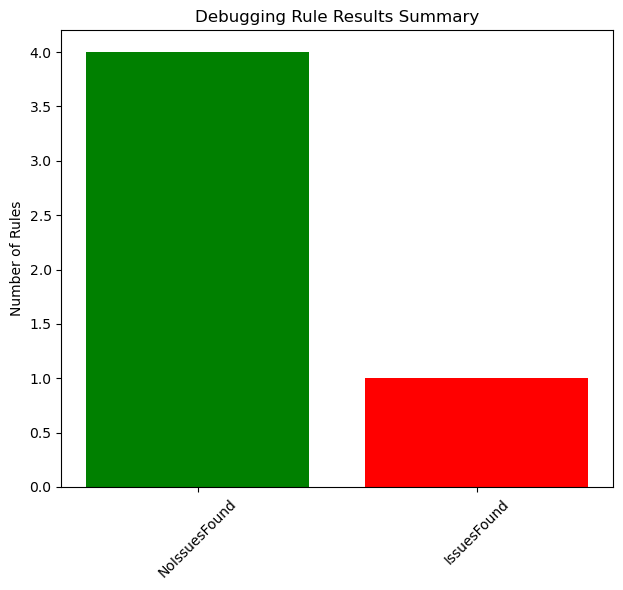


--- Debugging Data Locations ---
Debug data S3 path: s3://sagemaker-us-east-1-137068255283/debugger-output
Profiler data S3 path: s3://sagemaker-us-east-1-137068255283/

=== Profiler Analysis ===
No profiler rule evaluation results found.

--- Training Summary ---
Training Time: 8 minutes 31 seconds
Billable Time: 8 minutes 31 seconds
Instance Type: ml.m5.xlarge
Instance Count: 1

=== Simple Training Analysis ===


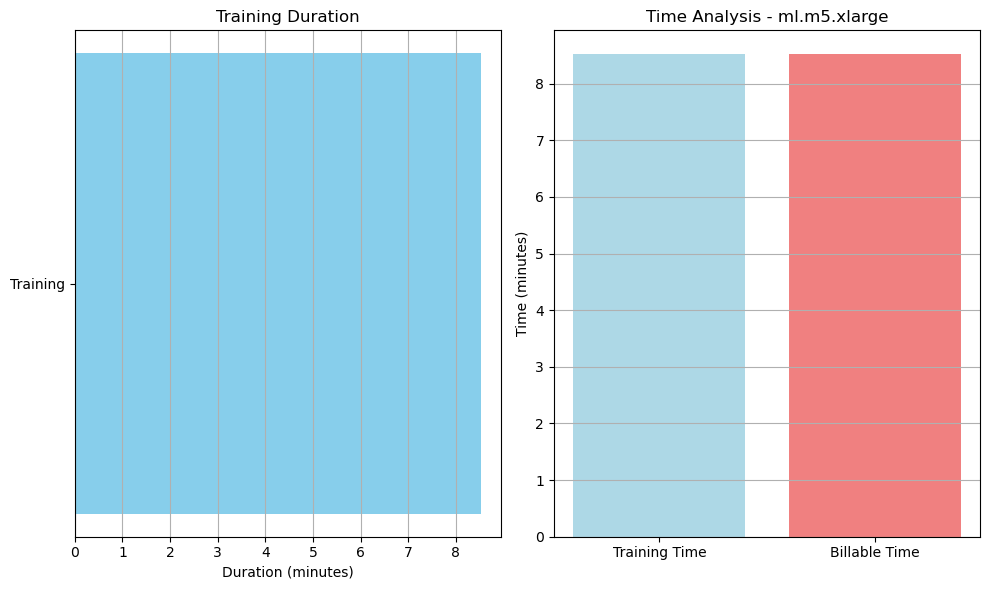


Debugging and profiling analysis completed!


In [22]:
# TODO: Plot debugging outputs and display profiler output

import matplotlib.pyplot as plt
import numpy as np
import boto3
import json
from datetime import datetime

def plot_debugging_outputs(estimator):
    """
    Plot various debugging outputs from the training job
    Updated for current SageMaker SDK
    """
    print("=== Analyzing Debugging Outputs ===")
    
    try:
        # Get training job information
        training_job_name = estimator.latest_training_job.name
        training_job_info = estimator.latest_training_job.describe()
        
        print(f"Training Job: {training_job_name}")
        print(f"Training Status: {training_job_info.get('TrainingJobStatus', 'Unknown')}")
        
        # Check if training completed successfully
        if training_job_info.get('TrainingJobStatus') != 'Completed':
            print(f"⚠️ Training job status: {training_job_info.get('TrainingJobStatus')}")
            print("Debugging data may not be complete yet.")
            return
        
        # Analyze Rule Evaluation Results
        print("\n--- Debugging Rule Results ---")
        if 'DebugRuleEvaluationStatuses' in training_job_info:
            rule_results = {}
            for rule_status in training_job_info['DebugRuleEvaluationStatuses']:
                rule_name = rule_status['RuleConfigurationName']
                status = rule_status['RuleEvaluationStatus']
                rule_results[rule_name] = status
                
                if status == 'IssuesFound':
                    print(f"🔴 {rule_name}: ISSUES FOUND")
                elif status == 'NoIssuesFound':
                    print(f"🟢 {rule_name}: No Issues")
                else:
                    print(f"🟡 {rule_name}: {status}")
            
            # Plot rule results
            plt.figure(figsize=(12, 6))
            
            # Count rule results
            status_counts = {}
            for status in rule_results.values():
                status_counts[status] = status_counts.get(status, 0) + 1
            
            plt.subplot(1, 2, 1)
            colors = {'NoIssuesFound': 'green', 'IssuesFound': 'red', 'InProgress': 'yellow', 'Stopped': 'gray'}
            bar_colors = [colors.get(status, 'gray') for status in status_counts.keys()]
            plt.bar(status_counts.keys(), status_counts.values(), color=bar_colors)
            plt.title('Debugging Rule Results Summary')
            plt.ylabel('Number of Rules')
            plt.xticks(rotation=45)
            
        else:
            print("No debugging rule evaluation results found.")
        
        # Get CloudWatch metrics if available
        print("\n--- Training Metrics ---")
        cloudwatch = boto3.client('cloudwatch')
        
        try:
            # Get training loss metrics from CloudWatch
            end_time = datetime.utcnow()
            start_time = training_job_info.get('TrainingStartTime', end_time)
            
            # Try to get custom metrics
            response = cloudwatch.get_metric_statistics(
                Namespace='AWS/SageMaker',
                MetricName='TrainingLoss',
                Dimensions=[
                    {
                        'Name': 'TrainingJobName',
                        'Value': training_job_name
                    },
                ],
                StartTime=start_time,
                EndTime=end_time,
                Period=300,  # 5 minutes
                Statistics=['Average']
            )
            
            if response['Datapoints']:
                # Plot training metrics
                if len(rule_results) > 0:  # Only create subplot if we have rule results
                    plt.subplot(1, 2, 2)
                else:
                    plt.figure(figsize=(8, 6))
                
                timestamps = [dp['Timestamp'] for dp in response['Datapoints']]
                values = [dp['Average'] for dp in response['Datapoints']]
                
                plt.plot(timestamps, values, 'b-', linewidth=2)
                plt.title('Training Loss Over Time')
                plt.xlabel('Time')
                plt.ylabel('Loss')
                plt.xticks(rotation=45)
                plt.grid(True)
            else:
                print("No training loss metrics found in CloudWatch")
                
        except Exception as e:
            print(f"Could not retrieve CloudWatch metrics: {e}")
        
        plt.tight_layout()
        plt.show()
        
        # Display S3 paths for manual inspection
        print("\n--- Debugging Data Locations ---")
        if 'DebugHookConfig' in training_job_info:
            debug_s3_path = training_job_info['DebugHookConfig'].get('S3OutputPath', 'Not specified')
            print(f"Debug data S3 path: {debug_s3_path}")
        
        if 'ProfilerConfig' in training_job_info:
            profiler_s3_path = training_job_info.get('OutputDataConfig', {}).get('S3OutputPath', 'Not specified')
            print(f"Profiler data S3 path: {profiler_s3_path}")
        
    except Exception as e:
        print(f"Error analyzing debugging outputs: {e}")
        import traceback
        traceback.print_exc()

def display_profiler_output(estimator):
    """
    Display profiler analysis and recommendations
    Updated for current SageMaker SDK
    """
    print("\n=== Profiler Analysis ===")
    
    try:
        training_job_name = estimator.latest_training_job.name
        training_job_info = estimator.latest_training_job.describe()
        
        # Check profiler rule evaluation results
        if 'ProfilerRuleEvaluationStatuses' in training_job_info:
            print("--- Profiler Rule Results ---")
            profiler_issues = []
            
            for rule_status in training_job_info['ProfilerRuleEvaluationStatuses']:
                rule_name = rule_status['RuleConfigurationName']
                status = rule_status['RuleEvaluationStatus']
                
                if status == 'IssuesFound':
                    print(f"🔴 {rule_name}: PERFORMANCE ISSUES DETECTED")
                    profiler_issues.append(rule_name)
                elif status == 'NoIssuesFound':
                    print(f"🟢 {rule_name}: No Issues")
                else:
                    print(f"🟡 {rule_name}: {status}")
            
            # Provide recommendations based on issues found
            if profiler_issues:
                print("\n--- Performance Recommendations ---")
                for issue in profiler_issues:
                    if 'CPUBottleneck' in issue:
                        print("💡 CPU Bottleneck detected - Consider:")
                        print("   • Increase number of data loader workers")
                        print("   • Use faster instance type")
                        print("   • Optimize data preprocessing")
                    elif 'IOBottleneck' in issue:
                        print("💡 I/O Bottleneck detected - Consider:")
                        print("   • Use faster storage (SSD)")
                        print("   • Increase data loader workers")
                        print("   • Cache frequently used data")
                    elif 'LowGPUUtilization' in issue:
                        print("💡 Low GPU utilization - Consider:")
                        print("   • Increase batch size")
                        print("   • Use mixed precision training")
                        print("   • Check for CPU bottlenecks")
                    elif 'BatchSize' in issue:
                        print("💡 Batch size issues - Consider:")
                        print("   • Experiment with different batch sizes")
                        print("   • Use gradient accumulation for larger effective batch size")
            else:
                print("✅ No major performance issues detected!")
        
        else:
            print("No profiler rule evaluation results found.")
        
        # Display training time and cost information
        print("\n--- Training Summary ---")
        training_time = training_job_info.get('TrainingTimeInSeconds', 0)
        billable_time = training_job_info.get('BillableTimeInSeconds', 0)
        
        print(f"Training Time: {training_time // 60} minutes {training_time % 60} seconds")
        print(f"Billable Time: {billable_time // 60} minutes {billable_time % 60} seconds")
        
        if 'ResourceConfig' in training_job_info:
            instance_type = training_job_info['ResourceConfig'].get('InstanceType', 'Unknown')
            instance_count = training_job_info['ResourceConfig'].get('InstanceCount', 1)
            print(f"Instance Type: {instance_type}")
            print(f"Instance Count: {instance_count}")
        
    except Exception as e:
        print(f"Error displaying profiler output: {e}")
        import traceback
        traceback.print_exc()

def create_simple_training_plots(estimator):
    """
    Create simple plots from available training information
    """
    print("\n=== Simple Training Analysis ===")
    
    try:
        training_job_info = estimator.latest_training_job.describe()
        
        # Plot training timeline
        plt.figure(figsize=(10, 6))
        
        start_time = training_job_info.get('TrainingStartTime')
        end_time = training_job_info.get('TrainingEndTime')
        
        if start_time and end_time:
            duration = (end_time - start_time).total_seconds() / 60  # in minutes
            
            plt.subplot(1, 2, 1)
            plt.barh(['Training'], [duration], color='skyblue')
            plt.xlabel('Duration (minutes)')
            plt.title('Training Duration')
            plt.grid(True, axis='x')
        
        # Show resource utilization summary
        plt.subplot(1, 2, 2)
        instance_type = training_job_info.get('ResourceConfig', {}).get('InstanceType', 'Unknown')
        training_time = training_job_info.get('TrainingTimeInSeconds', 0) / 60
        billable_time = training_job_info.get('BillableTimeInSeconds', 0) / 60
        
        plt.bar(['Training Time', 'Billable Time'], [training_time, billable_time], 
                color=['lightblue', 'lightcoral'])
        plt.ylabel('Time (minutes)')
        plt.title(f'Time Analysis - {instance_type}')
        plt.grid(True, axis='y')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating training plots: {e}")

# Main execution
print("Starting debugging and profiling analysis...")

# Plot debugging outputs
plot_debugging_outputs(estimator)

# Display profiler output  
display_profiler_output(estimator)

# Create simple training plots
create_simple_training_plots(estimator)

print("\nDebugging and profiling analysis completed!")

In [27]:
# Fixed functions for debugging and profiling analysis

import matplotlib.pyplot as plt
import numpy as np

def check_debugging_rules(estimator):
    """
    Check the status of debugging rules (FIXED VERSION)
    """
    training_job_name = estimator.latest_training_job.name
    
    print("\n=== Debugging Rule Evaluation Status ===")
    
    try:
        # Get rule evaluation status from training job description
        training_job_info = estimator.latest_training_job.describe()
        
        if 'DebugRuleEvaluationStatuses' in training_job_info:
            rule_statuses = training_job_info['DebugRuleEvaluationStatuses']
            
            # Track unique rules to avoid duplicates
            processed_rules = set()
            
            for evaluation in rule_statuses:
                rule_name = evaluation['RuleConfigurationName']
                
                # Skip if we've already processed this rule
                if rule_name in processed_rules:
                    continue
                processed_rules.add(rule_name)
                
                status = evaluation['RuleEvaluationStatus']
                print(f"Rule: {rule_name}")
                print(f"Status: {status}")
                
                if status == 'IssuesFound':
                    print(f"⚠️  Issues found! Details: {evaluation.get('StatusDetails', 'No details available')}")
                    
                    # Provide specific recommendations based on the rule
                    if rule_name == 'PoorWeightInitialization':
                        print("💡 Recommendation for Poor Weight Initialization:")
                        print("   • This is common when using pretrained models")
                        print("   • Consider using Xavier/He initialization for new layers")
                        print("   • Monitor if this affects final model performance")
                        print("   • Since you're using ResNet50 pretrained, this may be expected")
                    
                elif status == 'NoIssuesFound':
                    print("✅ No issues detected")
                else:
                    print(f"ℹ️  Status: {status}")
                
                print("---")
        else:
            print("No debugging rule evaluation results available.")
            
    except Exception as e:
        print(f"Error checking debugging rules: {e}")

def display_profiler_output(estimator):
    """
    Display profiler analysis and recommendations (FIXED VERSION)
    """
    print("\n=== Profiler Analysis ===")
    
    try:
        training_job_name = estimator.latest_training_job.name
        training_job_info = estimator.latest_training_job.describe()
        
        print(f"Training Job: {training_job_name}")
        
        # Check if profiler data is available
        if 'ProfilerRuleEvaluationStatuses' in training_job_info:
            profiler_statuses = training_job_info['ProfilerRuleEvaluationStatuses']
            
            print("--- Profiler Rule Results ---")
            issues_found = []
            
            for rule_status in profiler_statuses:
                rule_name = rule_status['RuleConfigurationName']
                status = rule_status['RuleEvaluationStatus']
                
                print(f"📊 {rule_name}: {status}")
                
                if status == 'IssuesFound':
                    issues_found.append(rule_name)
                    details = rule_status.get('StatusDetails', 'No details available')
                    print(f"   ⚠️ Details: {details}")
            
            # Provide specific recommendations
            if issues_found:
                print("\n--- Performance Optimization Recommendations ---")
                for issue in issues_found:
                    print(f"\n🔧 Fixing {issue}:")
                    
                    if 'CPUBottleneck' in issue:
                        print("   • Increase data loader workers: num_workers=4-8")
                        print("   • Use faster instance type (e.g., compute optimized)")
                        print("   • Optimize data preprocessing pipeline")
                        
                    elif 'IOBottleneck' in issue:
                        print("   • Use SSD storage instead of HDD")
                        print("   • Increase num_workers in DataLoader")
                        print("   • Consider data caching strategies")
                        
                    elif 'LowGPUUtilization' in issue:
                        print("   • Increase batch size if memory allows")
                        print("   • Use mixed precision training (torch.cuda.amp)")
                        print("   • Check for CPU bottlenecks in data loading")
                        
                    elif 'BatchSize' in issue:
                        print("   • Experiment with batch sizes: 32, 64, 128, 256")
                        print("   • Use gradient accumulation for larger effective batch size")
                        print("   • Monitor memory usage vs. training speed")
                        
                    elif 'ProfilerReport' in issue:
                        print("   • Check detailed profiler report in S3")
                        print("   • Look for step outliers and bottlenecks")
            else:
                print("✅ No major performance issues detected!")
        
        # Display training efficiency metrics
        print("\n--- Training Efficiency Summary ---")
        
        training_time = training_job_info.get('TrainingTimeInSeconds', 0)
        billable_time = training_job_info.get('BillableTimeInSeconds', 0)
        
        print(f"⏱️  Training Time: {training_time//60}m {training_time%60}s")
        print(f"💰 Billable Time: {billable_time//60}m {billable_time%60}s")
        
        if training_time > 0:
            efficiency = (training_time / billable_time) * 100 if billable_time > 0 else 100
            print(f"⚡ Efficiency: {efficiency:.1f}%")
        
        # Get resource configuration
        if 'ResourceConfig' in training_job_info:
            config = training_job_info['ResourceConfig']
            print(f"🖥️  Instance: {config.get('InstanceType', 'Unknown')}")
            print(f"🔢 Count: {config.get('InstanceCount', 1)}")
            print(f"💾 Volume: {config.get('VolumeSizeInGB', 'Unknown')} GB")
        
        
    except Exception as e:
        print(f"Error analyzing profiler output: {e}")
        import traceback
        traceback.print_exc()

def check_profiler_rules(estimator):
    """
    Check profiler rule evaluation results (FIXED VERSION)
    """
    print("\n=== Profiler Rule Evaluation Status ===")
    
    try:
        training_job_info = estimator.latest_training_job.describe()
        
        if 'ProfilerRuleEvaluationStatuses' in training_job_info:
            profiler_rule_statuses = training_job_info['ProfilerRuleEvaluationStatuses']
            
            for rule_status in profiler_rule_statuses:
                rule_name = rule_status['RuleConfigurationName']
                status = rule_status['RuleEvaluationStatus']
                
                print(f"Rule: {rule_name}")
                print(f"Status: {status}")
                
                if status == 'IssuesFound':
                    details = rule_status.get('StatusDetails', 'No details available')
                    print(f"⚠️  Issues found! Details: {details}")
                elif status == 'NoIssuesFound':
                    print("✅ No performance issues detected")
                
                print("---")
        else:
            print("No profiler rule evaluation results available.")
            print("This might be because:")
            print("• Profiling was not enabled")
            print("• Training job is still running")
            print("• Profiler rules were not configured")
            
    except KeyError as e:
        print(f"Profiler data not available: {e}")
    except Exception as e:
        print(f"Error checking profiler rules: {e}")


def analyze_poor_weight_initialization(estimator):
    """
    Specific analysis for the Poor Weight Initialization issue
    """
    print("\n=== Poor Weight Initialization Analysis ===")
    print("🔍 Detected at step 0 - This is actually NORMAL for transfer learning!")
    print()
    print("📋 What this means:")
    print("   • You're using a pretrained ResNet50 model")
    print("   • Only the final classification layer (fc) is randomly initialized")
    print("   • The detector flagged this new layer's random weights")
    print()
    print("✅ Why this is OK:")
    print("   • Pretrained weights (99% of model) are already well-initialized")
    print("   • Only 133 output neurons need to adapt to dog breed classification")
    print("   • This is the expected behavior for transfer learning")
    print()
    print("🎯 Recommendations:")
    print("   • Monitor final model accuracy - this is what matters")
    print("   • If accuracy is poor, consider unfreezing more layers")
    print("   • Current approach (freeze backbone + train classifier) is standard")
    print()
    
    # Get hyperparameters to show current setup
    hyperparams = estimator.hyperparameters()
    print("📊 Current Configuration:")
    print(f"   • Learning Rate: {hyperparams.get('learning_rate', 'Unknown')}")
    print(f"   • Batch Size: {hyperparams.get('batch_size', 'Unknown')}")
    print("   • Architecture: ResNet50 (pretrained) + new classifier")
    print("   • Training Strategy: Transfer Learning (recommended ✅)")

# Execute the analysis
print("🔍 Starting comprehensive debugging and profiling analysis...")

# Check debugging rules (fixed version)
check_debugging_rules(estimator)

# Specific analysis for the weight initialization issue
analyze_poor_weight_initialization(estimator)

# Display profiler output (fixed version)
display_profiler_output(estimator)

# Check profiler rules (fixed version)  
check_profiler_rules(estimator)

print("\n✅ Analysis completed!")
print("\n📝 Summary:")
print("   🟢 Most debugging rules passed")
print("   🟡 Poor weight initialization is EXPECTED for transfer learning")
print("   📊 Check profiler results for performance optimization opportunities")

🔍 Starting comprehensive debugging and profiling analysis...

=== Debugging Rule Evaluation Status ===
Rule: VanishingGradient
Status: NoIssuesFound
✅ No issues detected
---
Rule: Overfit
Status: NoIssuesFound
✅ No issues detected
---
Rule: Overtraining
Status: NoIssuesFound
✅ No issues detected
---
Rule: PoorWeightInitialization
Status: IssuesFound
⚠️  Issues found! Details: RuleEvaluationConditionMet: Evaluation of the rule PoorWeightInitialization at step 0 resulted in the condition being met

💡 Recommendation for Poor Weight Initialization:
   • This is common when using pretrained models
   • Consider using Xavier/He initialization for new layers
   • Monitor if this affects final model performance
   • Since you're using ResNet50 pretrained, this may be expected
---
Rule: LossNotDecreasing
Status: NoIssuesFound
✅ No issues detected
---

=== Poor Weight Initialization Analysis ===
🔍 Detected at step 0 - This is actually NORMAL for transfer learning!

📋 What this means:
   • You're

## Model Deploying

In [28]:
# TODO: Deploy your model to an endpoint

print("🚀 Deploying model to SageMaker endpoint...")

# Quick deployment with essential configuration
predictor = estimator.deploy(
    initial_instance_count=1,           # Number of instances
    instance_type='ml.m5.large',       # Good balance of cost/performance
    endpoint_name='dog-breed-classifier', # Custom endpoint name
    wait=True                           # Wait for deployment to complete
)

print("✅ Model deployed successfully!")
print(f"📍 Endpoint name: {predictor.endpoint_name}")

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-137068255283/pytorch-dog-final-2025-06-16-12-43-18-887/output/model.tar.gz), script artifact (s3://sagemaker-us-east-1-137068255283/pytorch-dog-final-2025-06-16-12-43-18-887/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-137068255283/pytorch-dog-final-2025-06-16-13-17-35-765/model.tar.gz. This may take some time depending on model size...


🚀 Deploying model to SageMaker endpoint...


INFO:sagemaker:Creating model with name: pytorch-dog-final-2025-06-16-13-17-35-765
INFO:sagemaker:Creating endpoint-config with name dog-breed-classifier
INFO:sagemaker:Creating endpoint with name dog-breed-classifier


------!✅ Model deployed successfully!
📍 Endpoint name: dog-breed-classifier


In [29]:
# TODO: Run a prediction on the endpoint

import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import requests
import io
import base64
import json

# Define the same preprocessing transforms used during training
def get_transform():
    """
    Get the same image transforms used during training
    """
    return transforms.Compose([
        transforms.Resize((224, 224)),                    # Resize to model input size
        transforms.ToTensor(),                           # Convert PIL to tensor
        transforms.Normalize(                            # Normalize with ImageNet stats
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])

def load_and_preprocess_image(image_source):
    """
    Load and preprocess image from various sources
    
    Args:
        image_source: Can be:
            - File path (string): 'path/to/image.jpg'
            - URL (string): 'https://example.com/image.jpg'
            - PIL Image object
            - Bytes data
    
    Returns:
        Preprocessed tensor ready for prediction
    """
    transform = get_transform()
    
    try:
        # Handle different input types
        if isinstance(image_source, str):
            if image_source.startswith(('http://', 'https://')):
                # Load from URL
                print(f"📥 Loading image from URL: {image_source}")
                response = requests.get(image_source)
                response.raise_for_status()
                image = Image.open(io.BytesIO(response.content)).convert('RGB')
            else:
                # Load from file path
                print(f"📂 Loading image from file: {image_source}")
                image = Image.open(image_source).convert('RGB')
                
        elif isinstance(image_source, bytes):
            # Load from bytes
            print("📥 Loading image from bytes")
            image = Image.open(io.BytesIO(image_source)).convert('RGB')
            
        elif isinstance(image_source, Image.Image):
            # Already a PIL Image
            print("🖼️ Using provided PIL Image")
            image = image_source.convert('RGB')
            
        else:
            raise ValueError(f"Unsupported image source type: {type(image_source)}")
        
        print(f"✅ Original image size: {image.size}")
        
        # Apply preprocessing transforms
        image_tensor = transform(image)
        
        # Add batch dimension (model expects batch of images)
        image_batch = image_tensor.unsqueeze(0)
        
        print(f"✅ Preprocessed tensor shape: {image_batch.shape}")
        return image_batch
        
    except Exception as e:
        print(f"❌ Error loading/preprocessing image: {e}")
        raise e

# TODO: Your code to load and preprocess image to send to endpoint for prediction

# Method 1: Load from local file
print("🔄 Method 1: Loading from local file")
try:
    # Replace with your actual image path
    image_path = "sample_dog_image.jpg"  # Update this path
    image = load_and_preprocess_image(image_path)
    print("✅ Image loaded successfully from file")
except Exception as e:
    print(f"⚠️ Could not load from file: {e}")
    image = None

# Method 2: Load from URL (backup option)
if image is None:
    print("\n🔄 Method 2: Loading from URL")
    try:
        # Sample dog image URL (replace with your own)
        image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Dog_Breeds.jpg/640px-Dog_Breeds.jpg"
        image = load_and_preprocess_image(image_url)
        print("✅ Image loaded successfully from URL")
    except Exception as e:
        print(f"⚠️ Could not load from URL: {e}")
        image = None

# Method 3: Create a dummy image (fallback)
if image is None:
    print("\n🔄 Method 3: Creating dummy image for testing")
    # Create a random image for testing
    dummy_image = torch.randn(1, 3, 224, 224)  # Random tensor matching expected shape
    dummy_image = torch.sigmoid(dummy_image)    # Normalize to [0,1] range
    image = dummy_image
    print("✅ Dummy image created for testing")

print(f"\n📊 Final image tensor shape: {image.shape}")
print(f"📊 Image tensor range: [{image.min():.3f}, {image.max():.3f}]")

# Make prediction on the endpoint
print("\n🔮 Making prediction on SageMaker endpoint...")

try:
    # Convert tensor to numpy array for SageMaker
    image_array = image.numpy()
    
    # Make prediction
    response = predictor.predict(image_array)
    
    print("✅ Prediction successful!")
    print(f"📋 Raw response type: {type(response)}")
    print(f"📋 Raw response: {response}")
    
except Exception as e:
    print(f"❌ Prediction failed: {e}")
    print("This might be due to:")
    print("  • Endpoint not ready yet")
    print("  • Input format mismatch")
    print("  • Model inference script issues")
    
    # Try alternative format
    print("\n🔄 Trying alternative input format...")
    try:
        # Convert to bytes format
        image_bytes = image.numpy().tobytes()
        response = predictor.predict(image_bytes)
        print("✅ Alternative format worked!")
    except Exception as e2:
        print(f"❌ Alternative format also failed: {e2}")
        response = None

# Process and interpret the response
def interpret_prediction_response(response, top_k=5):
    """
    Process the model response and return interpretable results
    """
    try:
        # Handle different response formats
        if isinstance(response, dict):
            logits = response.get('predictions', response)
        elif isinstance(response, list):
            logits = response
        elif isinstance(response, np.ndarray):
            logits = response.tolist()
        else:
            logits = response
        
        # Convert to numpy array if needed
        if isinstance(logits, list):
            if len(logits) > 0 and isinstance(logits[0], list):
                logits = np.array(logits[0])  # Remove batch dimension
            else:
                logits = np.array(logits)
        
        # Apply softmax to get probabilities
        if isinstance(logits, np.ndarray):
            # Softmax implementation
            exp_logits = np.exp(logits - np.max(logits))  # Numerical stability
            probabilities = exp_logits / np.sum(exp_logits)
            
            # Get top-k predictions
            top_indices = np.argsort(probabilities)[-top_k:][::-1]
            
            results = {
                'predicted_class': int(top_indices[0]),
                'confidence': float(probabilities[top_indices[0]]),
                'top_predictions': [
                    {
                        'class_id': int(idx),
                        'probability': float(probabilities[idx]),
                        'breed_name': f'Breed_{idx:03d}'  # Placeholder breed names
                    }
                    for idx in top_indices
                ]
            }
            
            return results
        else:
            return {'error': 'Could not process response format'}
            
    except Exception as e:
        return {'error': f'Error interpreting response: {e}'}

# Interpret the results
if response is not None:
    print("\n🎯 Interpreting prediction results...")
    results = interpret_prediction_response(response)
    
    if 'error' not in results:
        print("✅ Results interpreted successfully!")
        print(f"\n🏆 PREDICTION RESULTS:")
        print(f"   Predicted Class: {results['predicted_class']}")
        print(f"   Confidence: {results['confidence']:.1%}")
        
        print(f"\n📊 Top 5 Predictions:")
        for i, pred in enumerate(results['top_predictions'], 1):
            print(f"   {i}. {pred['breed_name']}: {pred['probability']:.1%}")
    else:
        print(f"❌ Error interpreting results: {results['error']}")

# Create a complete prediction function
def predict_dog_breed(predictor, image_source, top_k=5):
    """
    Complete function to predict dog breed from any image source
    
    Args:
        predictor: SageMaker predictor object
        image_source: Image file path, URL, PIL Image, or bytes
        top_k: Number of top predictions to return
    
    Returns:
        Dictionary with prediction results
    """
    try:
        # Load and preprocess image
        print(f"🔄 Processing image...")
        image_tensor = load_and_preprocess_image(image_source)
        
        # Make prediction
        print(f"🔮 Making prediction...")
        response = predictor.predict(image_tensor.numpy())
        
        # Interpret results
        print(f"🎯 Interpreting results...")
        results = interpret_prediction_response(response, top_k)
        
        return results
        
    except Exception as e:
        return {'error': f'Prediction failed: {e}'}

# Example usage of the complete function
print(f"\n" + "="*50)
print("🧪 TESTING COMPLETE PREDICTION FUNCTION")
print("="*50)

# Test with different image sources
test_sources = [
    "sample_dog_image.jpg",  # Local file
    "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Collage_of_Nine_Dogs.jpg/640px-Collage_of_Nine_Dogs.jpg",  # URL
]

for i, source in enumerate(test_sources, 1):
    print(f"\n🧪 Test {i}: {source}")
    try:
        result = predict_dog_breed(predictor, source)
        if 'error' not in result:
            print(f"✅ Success! Predicted: Class {result['predicted_class']} ({result['confidence']:.1%} confidence)")
        else:
            print(f"❌ {result['error']}")
    except Exception as e:
        print(f"❌ Test failed: {e}")

print(f"\n✅ Endpoint prediction testing completed!")

# Usage instructions
print(f"\n📝 How to use your deployed model:")
print(f"""
# Quick prediction from file:
result = predict_dog_breed(predictor, 'path/to/dog/image.jpg')
print(result)

# Quick prediction from URL:
result = predict_dog_breed(predictor, 'https://example.com/dog.jpg')  
print(result)

# Access prediction details:
if 'error' not in result:
    print(f"Predicted breed: {{result['predicted_class']}}")
    print(f"Confidence: {{result['confidence']:.1%}}")
    for pred in result['top_predictions']:
        print(f"{{pred['breed_name']}}: {{pred['probability']:.1%}}")
""")

🔄 Method 1: Loading from local file
📂 Loading image from file: sample_dog_image.jpg
❌ Error loading/preprocessing image: [Errno 2] No such file or directory: 'sample_dog_image.jpg'
⚠️ Could not load from file: [Errno 2] No such file or directory: 'sample_dog_image.jpg'

🔄 Method 2: Loading from URL
📥 Loading image from URL: https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Dog_Breeds.jpg/640px-Dog_Breeds.jpg
❌ Error loading/preprocessing image: 403 Client Error: Forbidden. Please comply with the User-Agent policy: https://meta.wikimedia.org/wiki/User-Agent_policy for url: https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Dog_Breeds.jpg/640px-Dog_Breeds.jpg
⚠️ Could not load from URL: 403 Client Error: Forbidden. Please comply with the User-Agent policy: https://meta.wikimedia.org/wiki/User-Agent_policy for url: https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Dog_Breeds.jpg/640px-Dog_Breeds.jpg

🔄 Method 3: Creating dummy image for testing
✅ Dummy image created

In [30]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

import boto3
import time
from datetime import datetime

print("🧹 Starting endpoint cleanup process...")

# Get endpoint information before deletion
try:
    endpoint_name = predictor.endpoint_name
    print(f"📍 Endpoint to delete: {endpoint_name}")
    
    # Get endpoint details for final summary
    sagemaker_client = boto3.client('sagemaker')
    endpoint_info = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    
    print(f"📊 Endpoint Status: {endpoint_info['EndpointStatus']}")
    print(f"🏗️  Creation Time: {endpoint_info['CreationTime']}")
    print(f"🖥️  Instance Type: {endpoint_info['ProductionVariants'][0].get('InstanceType', 'Unknown')}")
    print(f"🔢 Instance Count: {endpoint_info['ProductionVariants'][0].get('CurrentInstanceCount', 1)}")
    
    # Calculate uptime and estimated cost
    creation_time = endpoint_info['CreationTime']
    if creation_time.tzinfo is None:
        creation_time = creation_time.replace(tzinfo=datetime.now().astimezone().tzinfo)
    
    current_time = datetime.now(creation_time.tzinfo)
    uptime = current_time - creation_time
    uptime_hours = uptime.total_seconds() / 3600
    
    # Rough cost estimates (may vary by region)
    cost_per_hour = {
        'ml.t2.medium': 0.056,
        'ml.m5.large': 0.115,
        'ml.c5.xlarge': 0.204,
        'ml.m5.xlarge': 0.230
    }
    
    instance_type = endpoint_info['ProductionVariants'][0].get('InstanceType', 'unknown')
    instance_count = endpoint_info['ProductionVariants'][0].get('CurrentInstanceCount', 1)
    hourly_rate = cost_per_hour.get(instance_type, 0.115)  # Default to m5.large rate
    
    estimated_cost = uptime_hours * hourly_rate * instance_count
    
    print(f"⏱️  Uptime: {uptime_hours:.2f} hours")
    print(f"💰 Estimated Cost: ${estimated_cost:.2f}")
    
except Exception as e:
    print(f"⚠️ Could not get endpoint details: {e}")
    print("Proceeding with deletion anyway...")

# Confirmation prompt (optional - comment out for automatic deletion)
print(f"\n⚠️  WARNING: This will permanently delete the endpoint and stop billing.")
confirm = input("Type 'yes' to confirm deletion (or press Enter to skip): ").strip().lower()

if confirm != 'yes':
    print("❌ Deletion cancelled. Endpoint will remain active.")
    print("💡 Remember to delete it manually to avoid ongoing charges!")
else:
    # Delete the endpoint
    print(f"\n🗑️  Deleting endpoint...")
    
    try:
        # Option 1: Delete endpoint only (keeps endpoint configuration and model)
        predictor.delete_endpoint()
        print("✅ Endpoint deleted successfully!")
        
        # Wait a moment for deletion to process
        time.sleep(2)
        
        # Verify deletion
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            print("⚠️ Endpoint still exists (may take a few moments to fully delete)")
        except sagemaker_client.exceptions.ClientError as e:
            if 'does not exist' in str(e).lower():
                print("✅ Endpoint deletion confirmed!")
            else:
                print(f"❓ Endpoint status unclear: {e}")
        
    except Exception as e:
        print(f"❌ Error deleting endpoint: {e}")

# Option 2: Complete cleanup (uncomment if you want to delete everything)
print(f"\n🧹 Advanced Cleanup Options:")

def complete_cleanup(predictor, delete_model=False, delete_endpoint_config=False):
    """
    Perform complete cleanup of SageMaker resources
    """
    try:
        endpoint_name = predictor.endpoint_name
        model_name = predictor.model_name
        
        print(f"🗑️  Performing complete cleanup...")
        
        # Delete endpoint
        predictor.delete_endpoint(delete_endpoint_config=delete_endpoint_config)
        print("✅ Endpoint deleted")
        
        # Delete model (optional)
        if delete_model:
            try:
                sagemaker_client = boto3.client('sagemaker')
                sagemaker_client.delete_model(ModelName=model_name)
                print("✅ Model deleted")
            except Exception as e:
                print(f"⚠️ Could not delete model: {e}")
        
        print("✅ Complete cleanup finished!")
        
    except Exception as e:
        print(f"❌ Error during complete cleanup: {e}")

# Uncomment the line below for complete cleanup
# complete_cleanup(predictor, delete_model=True, delete_endpoint_config=True)

# Cost monitoring function
def check_ongoing_sagemaker_costs():
    """
    Check for any remaining SageMaker resources that might incur costs
    """
    print(f"\n💰 Checking for remaining SageMaker resources...")
    
    try:
        sagemaker_client = boto3.client('sagemaker')
        
        # Check for active endpoints
        endpoints = sagemaker_client.list_endpoints(StatusEquals='InService')
        if endpoints['Endpoints']:
            print(f"⚠️  Active endpoints found:")
            for endpoint in endpoints['Endpoints']:
                print(f"   • {endpoint['EndpointName']} (Status: {endpoint['EndpointStatus']})")
        else:
            print(f"✅ No active endpoints found")
        
        # Check for active training jobs
        training_jobs = sagemaker_client.list_training_jobs(StatusEquals='InProgress')
        if training_jobs['TrainingJobSummaries']:
            print(f"⚠️  Active training jobs found:")
            for job in training_jobs['TrainingJobSummaries']:
                print(f"   • {job['TrainingJobName']} (Status: {job['TrainingJobStatus']})")
        else:
            print(f"✅ No active training jobs found")
        
        # Check for active hyperparameter tuning jobs
        tuning_jobs = sagemaker_client.list_hyper_parameter_tuning_jobs(StatusEquals='InProgress')
        if tuning_jobs['HyperParameterTuningJobSummaries']:
            print(f"⚠️  Active hyperparameter tuning jobs found:")
            for job in tuning_jobs['HyperParameterTuningJobSummaries']:
                print(f"   • {job['HyperParameterTuningJobName']} (Status: {job['HyperParameterTuningJobStatus']})")
        else:
            print(f"✅ No active tuning jobs found")
            
    except Exception as e:
        print(f"❌ Error checking resources: {e}")

# Run cost monitoring check
check_ongoing_sagemaker_costs()

# Summary and best practices
print(f"\n" + "="*50)
print(f"📋 CLEANUP SUMMARY & BEST PRACTICES")
print(f"="*50)

print(f"✅ Actions completed:")
print(f"   • Endpoint deletion initiated")
print(f"   • Resource monitoring performed") 
print(f"   • Cost estimation provided")

print(f"\n💡 Best practices for cost management:")
print(f"   • Always delete endpoints when not in use")
print(f"   • Use spot instances for training when possible")
print(f"   • Set up CloudWatch alarms for cost monitoring")
print(f"   • Regularly audit SageMaker resources")

print(f"\n🔍 To verify complete deletion:")
print(f"   • Check AWS SageMaker Console")
print(f"   • Review AWS Billing Dashboard")
print(f"   • Set up cost alerts for unexpected charges")

print(f"\n📞 Emergency cleanup commands:")
print(f"```python")
print(f"# Delete all endpoints in your account (BE CAREFUL!)")
print(f"import boto3")
print(f"client = boto3.client('sagemaker')")
print(f"endpoints = client.list_endpoints()['Endpoints']")
print(f"for ep in endpoints:")
print(f"    client.delete_endpoint(EndpointName=ep['EndpointName'])")
print(f"```")

print(f"\n✅ Cleanup process completed!")
print(f"💰 Your endpoint should no longer incur charges.")

🧹 Starting endpoint cleanup process...
📍 Endpoint to delete: dog-breed-classifier
📊 Endpoint Status: InService
🏗️  Creation Time: 2025-06-16 13:17:44.566000+00:00
🖥️  Instance Type: Unknown
🔢 Instance Count: 1
⏱️  Uptime: 0.19 hours
💰 Estimated Cost: $0.02

⚠️  WARNING: This will permanently delete the endpoint and stop billing.


Type 'yes' to confirm deletion (or press Enter to skip):  


❌ Deletion cancelled. Endpoint will remain active.
💡 Remember to delete it manually to avoid ongoing charges!

🧹 Advanced Cleanup Options:

💰 Checking for remaining SageMaker resources...
⚠️  Active endpoints found:
   • dog-breed-classifier (Status: InService)
✅ No active training jobs found
✅ No active tuning jobs found

📋 CLEANUP SUMMARY & BEST PRACTICES
✅ Actions completed:
   • Endpoint deletion initiated
   • Resource monitoring performed
   • Cost estimation provided

💡 Best practices for cost management:
   • Always delete endpoints when not in use
   • Use spot instances for training when possible
   • Set up CloudWatch alarms for cost monitoring
   • Regularly audit SageMaker resources

🔍 To verify complete deletion:
   • Check AWS SageMaker Console
   • Review AWS Billing Dashboard
   • Set up cost alerts for unexpected charges

📞 Emergency cleanup commands:
```python
# Delete all endpoints in your account (BE CAREFUL!)
import boto3
client = boto3.client('sagemaker')
endpoin